In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./DyHead/atss_r50_fpn_dyhead_1x_coco.py')

root='/opt/ml/detection/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True
cfg.work_dir = './work_dirs/atss_r50_fpn_dyhead_1x'

cfg.data.samples_per_gpu = 32

cfg.seed=2021
cfg.gpu_ids = [1]

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./DyHead/atss_r50_fpn_dyhead_1x_coco.py')

root='/opt/ml/detection/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True
cfg.work_dir = './work_dirs/atss_r50_fpn_dyhead_1x'

cfg.data.samples_per_gpu = 32

cfg.seed=2021
cfg.gpu_ids = [1]

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [4]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=32,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [5]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/detection/baseline/mmdetection/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: ./work_dirs/atss_r50_fpn_dyhead_1x/latest.pth


In [6]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 26.3 task/s, elapsed: 185s, ETA:     0s

In [7]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


,PredictionString,image_id
0,0 0.1378196 141.63588 428.75983 202.92867 457....,test/0000.jpg
1,0 0.23667386 639.2584 663.5138 684.7693 828.73...,test/0001.jpg
2,0 0.41978577 874.2766 468.09253 1024.0 629.830...,test/0002.jpg
3,0 0.17655943 155.12442 268.97736 920.50916 810...,test/0003.jpg
4,0 0.31894177 415.3637 404.98203 653.6015 589.1...,test/0004.jpg


In [8]:
from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO

In [9]:
new_pred = []

file_names = submission['image_id'].values.tolist()
bboxes = submission['PredictionString'].values.tolist()

for i, bbox in enumerate(bboxes):
    if isinstance(bbox,float):
        print(f'{file_names[i]} empty box')

# 이미지 파일별 해당 객체 id, bbox, area , category id , image_id 생성
df = pd.DataFrame(columns=["file_name","label_index","confidence_score","x_min","x_max","y_min","y_max"])
result_dict = dict()
for file_name, bbox in tqdm(zip(file_names, bboxes)):
    boxes = np.array(bbox.split(" "))
    
    if len(boxes) % 6 == 1:
        annotation = boxes[:-1].reshape(-1, 6)
    elif len(boxes) % 6 == 0:
        annotation = boxes.reshape(-1, 6)
    else:
        raise Exception('error', 'invalid box count')
    
    for an in annotation:
        new_pred.append([file_name,float(an[0]),float(an[1]),float(an[2]),float(an[4]),float(an[3]),float(an[5])])

4871it [00:04, 994.20it/s] 


In [10]:
df = pd.DataFrame(new_pred,columns=["file_name","label_index","confidence_score","x_min","x_max","y_min","y_max"])

In [11]:
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

label_dict = {}
for idx,name in enumerate(LABEL_NAME):
    label_dict[idx] = name

df["label_index"] = df["label_index"].apply(lambda x: label_dict[x])

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


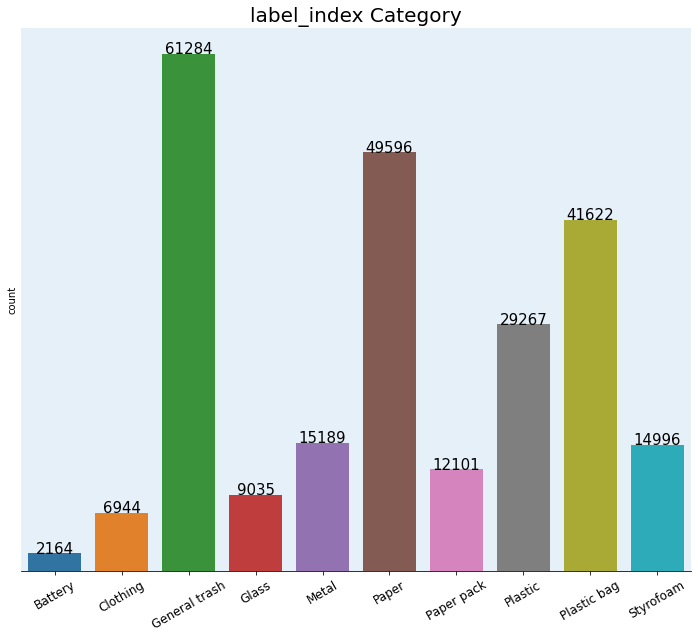

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
EDA_columns = ["label_index"]

def EDA(EDA_columns):
    plt.figure(figsize=(12,10))

    for i in range(len(EDA_columns)):
        ax = sns.countplot(sorted(df[EDA_columns[i]]))
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, height,ha = 'center', size = 15)
        
        plt.title(EDA_columns[i] + " Category",size=20)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.yticks([])
        plt.xticks(rotation=30,size=12)
        plt.gca().set_facecolor('#E6F0F8')


EDA(EDA_columns)

test/3716.jpg


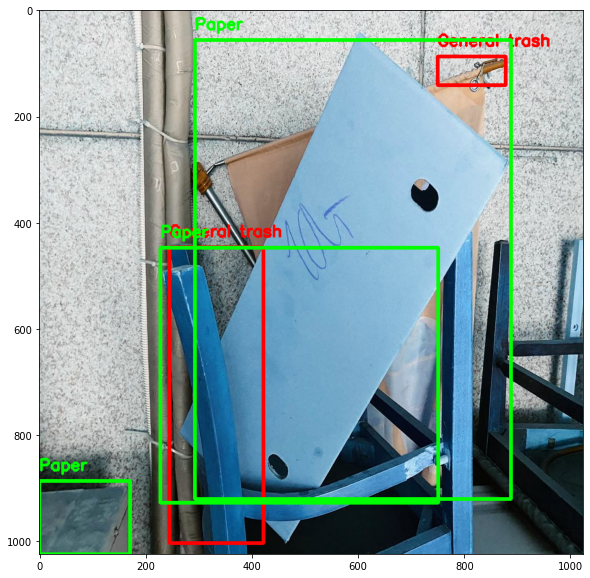

In [23]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt

# class 별 bbox 색
colors = [
    (255, 0, 0), 
    (0, 255, 0),
    (0, 0, 255),
    (127, 127, 0),
    (127, 0, 127),
    (0, 127, 127),
    (200, 200, 200),
    (50, 150, 200),
    (200, 155, 50),
    (130, 198, 20),
]
labels = {0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}

# 이미지 경로
img_dir = '/opt/ml/detection/dataset/'
# output 파일 경로
output_dir = './work_dirs/cascade_rcnn_r50_fpn_1x_trash/submission_latest.csv'
# output_dir = '/opt/ml/detection/dataset/train.json'

test_result = pd.read_csv(output_dir)

file_names = test_result['image_id'].values.tolist()
bboxes = test_result['PredictionString'].values.tolist()

idx = random.choice(range(len(file_names)))
# idx = 13
file_name = file_names[idx]
print(file_name)
bbox = bboxes[idx].split()

image = cv2.imread(os.path.join(img_dir, file_name)).astype(np.uint8)
for i in range(0, len(bbox), 6):
    label = int(bbox[i])
    x_min = int(bbox[i + 2].split('.')[0])
    y_min = int(bbox[i + 3].split('.')[0])
    x_max = int(bbox[i + 4].split('.')[0])
    y_max = int(bbox[i + 5].split('.')[0])
    
    # bounding box 그리기
    image = cv2.rectangle(image, pt1=(x_min, y_min), pt2=(x_max, y_max), color=colors[label], thickness=5)
    # label text 넣기
    cv2.putText(image, labels[label], (x_min, y_min - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 3)

plt.figure(figsize=(10,10))
plt.imshow(image)